In [1]:
import json
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# Loading the sarcasm dataset

with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    datastore = [json.loads(line) for line in f]

In [6]:
sentences, labels = [], []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Output dimensions of the Embedding layer
EMBEDDING_DIM = 16

In [8]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

In [9]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)

# Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

Unlike the previous lab (i.e. IMDB reviews), the data you're using here is not yet a `tf.data.Dataset` but a list. Thus, you can pass it directly to the `vectorize_layer` as shown below.

In [10]:
# Apply the vectorization layer on the train and test inputs
train_sequences = vectorize_layer(train_sentences)
test_sequences = vectorize_layer(test_sentences)

In [12]:
train_sequences.shape

TensorShape([20000, 32])

In [13]:
# Now you will combine the inputs and labels into a `tf.data.Dataset` to prepare it for training.
# Combine input-output pairs for training

train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences,train_labels))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences,test_labels))

In [14]:
# View 2 examples
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 319,    1,  943, 4079, 2366,   47,  366,   94, 2026,    6, 2653,
       9469,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([   4, 7185, 3128, 3305,   28,    2,  152,    1,  358, 2902,    6,
        236,    9,  843,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [15]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

Next, you will build the model. The architecture is similar to the previous lab but you will use a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays (i.e. `(10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [16]:
# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


This added computation reduces the dimensionality of the model as compared to using `Flatten()` and thus, the number of training parameters will also decrease. See the output of `model.summary()` below and see how it compares if you swap out the pooling layer with a simple `Flatten()`.

In [17]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
num_epochs = 10

# Train the model
history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final, verbose=2)

Epoch 1/10
625/625 - 6s - loss: 0.5753 - accuracy: 0.6921 - val_loss: 0.4137 - val_accuracy: 0.8193 - 6s/epoch - 10ms/step
Epoch 2/10
625/625 - 3s - loss: 0.3198 - accuracy: 0.8719 - val_loss: 0.3609 - val_accuracy: 0.8371 - 3s/epoch - 4ms/step
Epoch 3/10
625/625 - 3s - loss: 0.2424 - accuracy: 0.9046 - val_loss: 0.3504 - val_accuracy: 0.8498 - 3s/epoch - 4ms/step
Epoch 4/10
625/625 - 3s - loss: 0.1966 - accuracy: 0.9263 - val_loss: 0.3683 - val_accuracy: 0.8512 - 3s/epoch - 4ms/step
Epoch 5/10
625/625 - 3s - loss: 0.1647 - accuracy: 0.9395 - val_loss: 0.3934 - val_accuracy: 0.8498 - 3s/epoch - 4ms/step
Epoch 6/10
625/625 - 3s - loss: 0.1401 - accuracy: 0.9514 - val_loss: 0.4240 - val_accuracy: 0.8465 - 3s/epoch - 4ms/step
Epoch 7/10
625/625 - 2s - loss: 0.1216 - accuracy: 0.9596 - val_loss: 0.4596 - val_accuracy: 0.8435 - 2s/epoch - 4ms/step
Epoch 8/10
625/625 - 3s - loss: 0.1079 - accuracy: 0.9650 - val_loss: 0.5169 - val_accuracy: 0.8329 - 3s/epoch - 4ms/step
Epoch 9/10
625/625 - 3s

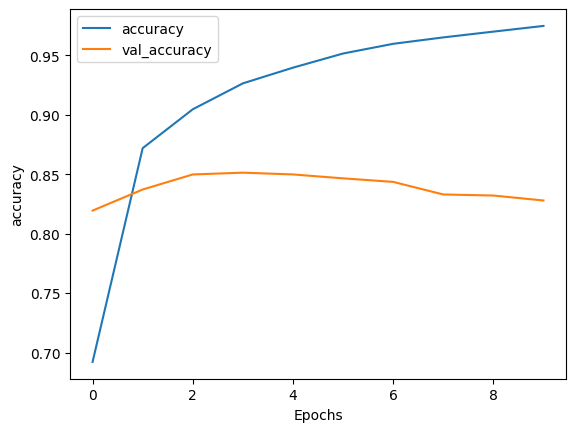

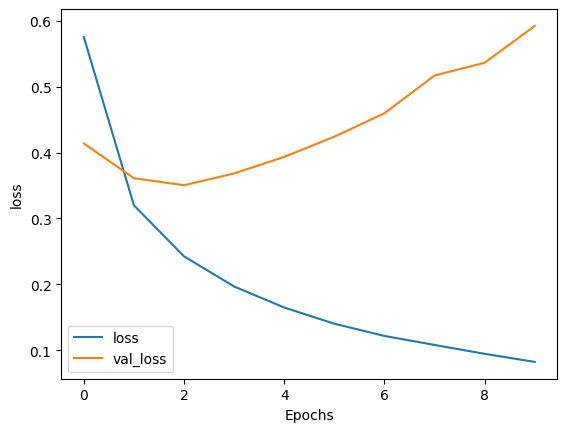

In [20]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In this lab, you were able to build a binary classifier to detect sarcasm. You saw some overfitting in the initial attempt and hopefully, you were able to arrive at a better set of hyperparameters.

So far, you've been tokenizing datasets from scratch and you're treating the vocab size as a hyperparameter. Furthermore, you're tokenizing the texts by building a vocabulary of full words. In the next lab, you will make use of a pre-tokenized dataset that uses a vocabulary of *subwords*. For instance, instead of having a unique token for the word `Tensorflow`, it will instead have a token each for `Ten`, `sor`, and `flow`.